# MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data


In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

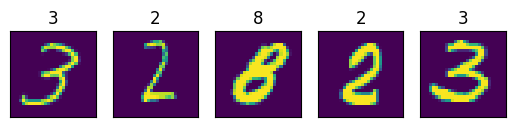

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dims = [int(mnist_dim/8)]
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dims, output_dim

(784, [98], 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train);
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8367       0.8905        0.3961  1.4449
      2        0.4284       0.9098        0.3098  0.9784
      3        0.3556       0.9241        0.2624  0.9305
      4        0.3177       0.9331        0.2324  0.9178
      5        0.2917       0.9386        0.2125  0.9308
      6        0.2702       0.9412        0.1987  0.9260
      7        0.2533       0.9436        0.1900  0.9250
      8        0.2380       0.9490        0.1747  0.9257
      9        0.2291       0.9503        0.1688  0.9304
     10        0.2202       0.9527        0.1576  1.0343
     11        0.2106       0.9535        0.1554  1.5683
     12        0.2033       0.9557        0.1476  1.6105
     13        0.1999       0.9578        0.1457  0.9156
     14        0.1932       0.9564        0.1451  0.9096
     15        0.1892       0.9600        0.1360  0.9168
     16        0.1848       0.9

In [ ]:
net1.module.forward(torch.tensor(X_test).to(device),eval=True)

(tensor([[2.0147e-08, 1.4814e-07, 3.7713e-04,  ..., 1.5613e-07, 9.9909e-01,
          4.8031e-07],
         [1.6016e-09, 1.3437e-09, 1.3737e-08,  ..., 3.8516e-04, 3.9539e-06,
          2.0088e-04],
         [3.0025e-03, 7.1981e-04, 6.2094e-03,  ..., 6.9021e-04, 6.0456e-01,
          1.1844e-02],
         ...,
         [2.3549e-05, 2.7039e-08, 1.9762e-06,  ..., 1.2048e-08, 1.8480e-05,
          7.3559e-05],
         [1.0057e-06, 1.4489e-08, 2.9837e-05,  ..., 1.1928e-05, 1.3349e-02,
          9.7282e-01],
         [1.1720e-05, 8.4182e-05, 9.7499e-01,  ..., 6.5959e-04, 1.3144e-03,
          2.2216e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([[0.7680, 0.0000, 1.7802,  ..., 0.0000, 0.0000, 1.1300],
         [0.0000, 0.2991, 0.0000,  ..., 0.0000, 0.0000, 0.1477],
         [0.2638, 0.1413, 0.0000,  ..., 0.0000, 0.0000, 0.4819],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1217, 0.0000, 0.0000],
         [0.0000, 3.0441, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
      

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9621142857142857

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1706       0.8329        0.5378  0.9967
      2        0.5422       0.9035        0.3359  1.0612
      3        0.4359       0.9195        0.2755  1.3266
      4        0.3662       0.9332        0.2221  1.1074
      5        0.3185       0.9320        0.2238  0.9603
      6        0.2814       0.9479        0.1776  0.9770
      7        0.2571       0.9503        0.1620  0.9722
      8        0.2357       0.9525        0.1567  0.9712
      9        0.2198       0.9533        0.1542  0.9570
     10        0.2045       0.9540        0.1585  0.9594
     11        0.1908       0.9580        0.1409  1.0077
     12        0.1804       0.9085        0.3134  0.9727
     13        0.1705       0.9638        0.1253  0.9783
     14        0.1628       0.9647        0.1231  1.1683
     15        0.1568       0.9615        0.1321  1.3543
     16        0.1489       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9638857142857142

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0867       0.8451        0.5136  0.9897
      2        0.5002       0.8920        0.3616  0.9773
      3        0.4027       0.9180        0.2784  0.9771
      4        0.3441       0.9276        0.2376  0.9619
      5        0.3032       0.9339        0.2172  1.0986
      6        0.2728       0.9455        0.1858  1.3285
      7        0.2463       0.9487        0.1705  1.0680
      8        0.2261       0.9511        0.1614  0.9713
      9        0.2104       0.9518        0.1599  0.9798
     10        0.1940       0.9530        0.1544  0.9776
     11        0.1852       0.9546        0.1497  0.9583
     12        0.1735       0.9570        0.1423  0.9619
     13        0.1664       0.9501        0.1662  0.9839
     14        0.1556       0.9524        0.1540  0.9817
     15        0.1496       0.9617        0.1261  0.9719
     16        0.1439       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9594857142857143

In [ ]:
error_mask = y_pred != y_test

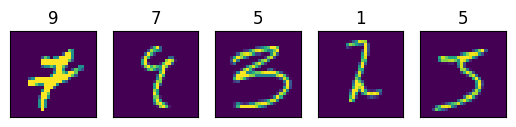

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0957       0.8624        0.4572  1.4767
      2        0.4814       0.9075        0.3147  0.9795
      3        0.3856       0.9122        0.2830  0.9696
      4        0.3339       0.9127        0.2719  0.9716
      5        0.2892       0.9384        0.1990  0.9838
      6        0.2607       0.9395        0.1971  1.3262
      7        0.2374       0.9490        0.1726  1.3820
      8        0.2191       0.9500        0.1656  0.9572
      9        0.2024       0.9504        0.1636  0.9648
     10        0.1889       0.9550        0.1492  0.9734
     11        0.1759       0.9573        0.1413  0.9856
     12        0.1653       0.9583        0.1379  0.9626
     13        0.1596       0.9585        0.1365  0.9627
     14        0.1502       0.9596        0.1340  0.9557
     15        0.1450       0.9591        0.1309  0.9660
     16        0.1378       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.9632571428571428

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2789       0.2133        2.0612  2.5305
      2        1.7379       0.4841        1.3003  3.7592
      3        1.0789       0.6756        0.9104  2.1363
      4        0.8317       0.4943        1.9401  1.3569
      5        0.7630       0.8568        0.4957  2.1137
      6        0.6738       0.8770        0.4603  2.4785
      7        0.6295       0.8916        0.4092  2.7686
      8        0.5916       0.8610        0.4787  2.9438
      9        0.5569       0.9118        0.3460  1.5647
     10        0.5410       0.9110        0.3483  1.1440
     11        0.5153       0.9227        0.3239  1.1291
     12        0.4848       0.8533        0.6047  1.1323
     13        0.4763       0.9225        0.3239  1.1796
     14        0.4574       0.9307        0.2951  1.1450
     15        0.4349       0.9255        0.3040  1.1668
     16        0.4292       0.9

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.936

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = corr.cpu().detach().numpy()
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.6441813
correlation between net1 and net3: 0.64617383
correlation between net1 and net4: 0.6419462
correlation between net1 and net5: 0.5344021
correlation between net2 and net3: 0.69737905
correlation between net2 and net4: 0.6987282
correlation between net2 and net5: 0.56351495
correlation between net3 and net4: 0.7301064
correlation between net3 and net5: 0.55107325
correlation between net4 and net5: 0.54149276


# Convolutional Network


In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4314       0.9716        0.0900  2.0413
      2        0.1635       0.9804        0.0628  1.5684
      3        0.1336       0.9838        0.0554  1.5583
      4        0.1130       0.9851        0.0499  1.7229
      5        0.1016       0.9863        0.0446  1.9671
      6        0.0959       0.9880        0.0398  1.5590
      7        0.0860       0.9870        0.0410  1.5439
      8        0.0837       0.9879        0.0382  1.5647
      9        0.0804       0.9894        0.0356  1.5608
     10        0.0758       0.9893        0.0364  1.5571


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9866857142857143

In [ ]:
X_test.shape

(17500, 784)

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.8798602
correlation between net2 and cnn: 0.8562551
correlation between net3 and cnn: 0.9083873
correlation between net4 and cnn: 0.83104825
correlation between net5 and cnn: 0.41640413
